In [1]:
import os

if not os.path.exists("datasets/"):
    os.mkdir("datasets")

In [3]:
!wget --header="User-Agent: Mozilla/5.0" -O datasets/steam_reviews.json.gz http://cseweb.ucsd.edu/~wckang/steam_reviews.json.gz
!wget --header="User-Agent: Mozilla/5.0" -O datasets/steam_games.json.gz http://cseweb.ucsd.edu/~wckang/steam_games.json.gz

--2025-10-20 13:14:27--  http://cseweb.ucsd.edu/~wckang/steam_reviews.json.gz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~wckang/steam_reviews.json.gz [following]
--2025-10-20 13:14:27--  https://cseweb.ucsd.edu//~wckang/steam_reviews.json.gz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1338063248 (1.2G) [application/x-gzip]
Saving to: ‘datasets/steam_reviews.json.gz’

datasets/steam_revi 100%[===================>]   1.25G  2.99MB/s    in 3m 46s  

2025-10-20 13:18:35 (5.64 MB/s) - ‘datasets/steam_reviews.json.gz’ saved [1338063248/1338063248]

--2025-10-20 13:18:35--  http://cseweb.ucsd.edu/~wckang/steam_games.json.gz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd

In [6]:
import gzip
import shutil

# Ruta del archivo .gz
gz_path = "datasets/steam_games.json.gz"

# Ruta de destino sin compresión
output_path = "datasets/steam_games.json"

# Descomprimir
with gzip.open(gz_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


# Ruta del archivo .gz
gz_path = "datasets/steam_reviews.json.gz"

# Ruta de destino sin compresión
output_path = "datasets/steam_new.json"

# Descomprimir
with gzip.open(gz_path, 'rb') as f_in:
    with open(output_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [1]:
#codigo para cargar los datos en 2 df, uno para el game_info y otro para las reviews

import pandas as pd
import ast

def json_line_generator(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if line:
                data_object = ast.literal_eval(line)
                yield data_object


df_games = pd.DataFrame(json_line_generator("datasets/steam_games.json"))
df_reviews = pd.DataFrame(json_line_generator("datasets/steam_new.json"))
print("Número total de registros cargados en df_games:", len(df_games))

print("\nNúmero total de registros cargados en df_reviews:", len(df_reviews))

Número total de registros cargados en df_games: 32135

Número total de registros cargados en df_reviews: 7793069


In [2]:
#poner una columna de el nombre del juego en el df de reviews
df_games_info = df_games[['id', 'title']].rename(columns={'id': 'product_id', 'title': 'game_title'})
df_reviews = pd.merge(
    df_reviews,                       
    df_games_info,                    
    on='product_id',                  
    how='left'                        
)

In [3]:
#verificación
df_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,Psi Project
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN,Gunspell - Steam Edition
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN,Gunspell - Steam Edition
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN,Batman: Arkham Asylum Game of the Year Edition
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075,Batman: Arkham Asylum Game of the Year Edition


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess_text(text):
    if text is None or text == "":
        return []
    
    #minuscula + ruido
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) #URLs
    text = re.sub(r'<.*?>', '', text)       #etiquetas HTML
    text = re.sub(r'[^a-záéíóúüñ\s]', '', text) #caracteres no alfabéticos 

    #tokenizacion
    tokens = word_tokenize(text)
    
    #stopwords 
    spanish_stopwords = set(stopwords.words('spanish'))
    english_stopwords = set(stopwords.words('english'))
    all_stopwords = spanish_stopwords.union(english_stopwords)

    filtered_tokens = [word for word in tokens if word not in all_stopwords and len(word) > 1]
    
    return filtered_tokens

df_reviews['processed_tokens'] = df_reviews['text'].apply(preprocess_text)
df_reviews['processed_text'] = df_reviews['processed_tokens'].apply(lambda x: ' '.join(x))

In [5]:
df_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title,processed_tokens,processed_text
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,Psi Project,"[would, acceptable, entertainment, even, back,...",would acceptable entertainment even back day g...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN,Gunspell - Steam Edition,"[looks, like, facebook, game]",looks like facebook game
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN,Gunspell - Steam Edition,"[better, minecraft]",better minecraft
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN,Batman: Arkham Asylum Game of the Year Edition,"[love, idolized, batman, game, masterpiece]",love idolized batman game masterpiece
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075,Batman: Arkham Asylum Game of the Year Edition,"[still, worth, playing, probably, favorite, ba...",still worth playing probably favorite batman g...


Número total de reviews procesadas: 7671591
Loss after epoch 0: 63417420.0
Loss after epoch 1: 12285292.0
Loss after epoch 2: 9193464.0
Loss after epoch 3: 9019048.0
Loss after epoch 4: 8585912.0
Loss after epoch 5: 8245360.0
Loss after epoch 6: 7664432.0
Loss after epoch 7: 6981712.0
Loss after epoch 8: 5975824.0
Loss after epoch 9: 2849264.0

Vocabulario construido con 257921 palabras únicas


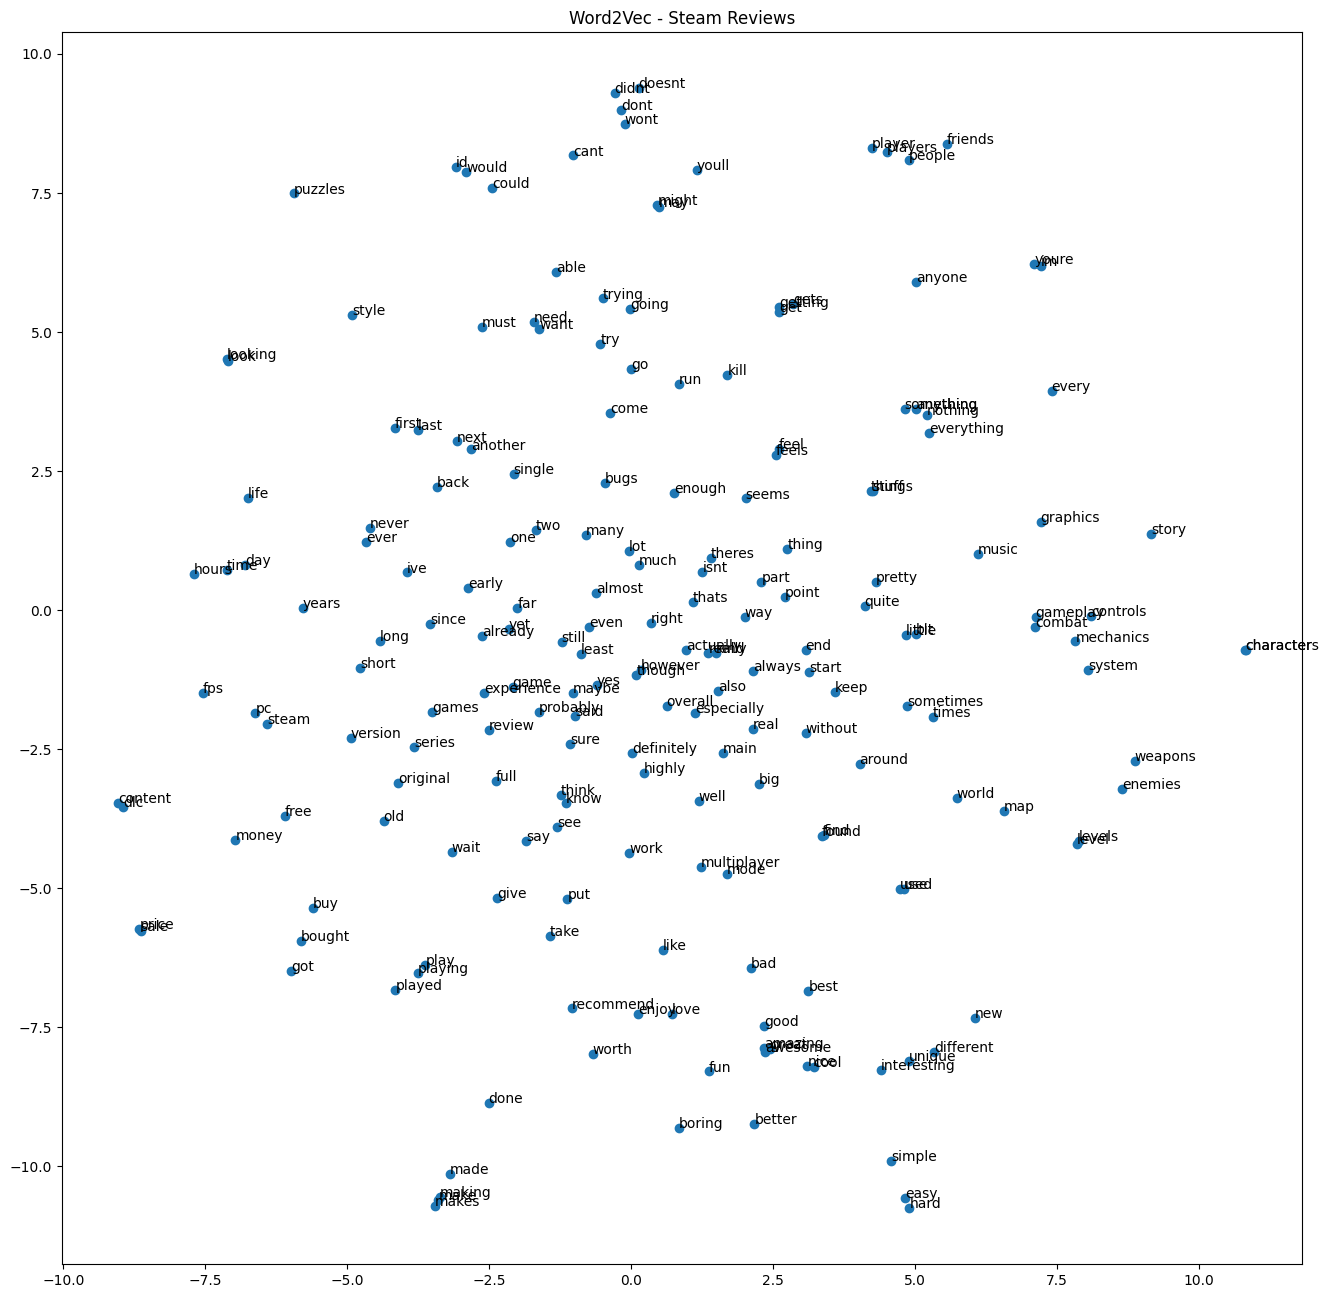

In [6]:
#Crear word2vec con los tokens procesados

import gensim.models
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


class EpochLogger(CallbackAny2Vec):
    '''Callback to log information about training'''

    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss - self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

sentences = [tokens for tokens in df_reviews['processed_tokens'].values if len(tokens) > 0]

print(f"Número total de reviews procesadas: {len(sentences)}")

#crear Word2Vec
epoch_logger = EpochLogger()

model = gensim.models.Word2Vec(
    sentences=sentences, 
    vector_size=200, 
    window=5, 
    min_count=5,  
    compute_loss=True, 
    callbacks=[epoch_logger], 
    negative=5, 
    epochs=10,  
    workers=4  
    
)

print(f"\nVocabulario construido con {len(model.wv)} palabras únicas")

# Visualización con TSNE
# Selecciona las primeras 200 palabras más frecuentes
words = list(model.wv.index_to_key)[:200]
vectors = [model.wv[word] for word in words]

# Aplica TSNE
tsne = TSNE(n_components=2, random_state=0, perplexity=30)
tsne_vectors = tsne.fit_transform(np.array(vectors))

plt.figure(figsize=(16, 16))
plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, (tsne_vectors[i, 0], tsne_vectors[i, 1]))

plt.title('Word2Vec - Steam Reviews')
plt.show()



In [7]:
#ejemplos
print("\nEjemplos de palabras similares")
test_words = ['game', 'good', 'bad', 'fun', 'play']
for word in test_words:
    if word in model.wv:
        print(f"\nPalabras similares a '{word}':")
        similar = model.wv.most_similar(word, topn=5)
        for similar_word, score in similar:
            print(f"  {similar_word}: {score:.4f}")


Ejemplos de palabras similares

Palabras similares a 'game':
  gameit: 0.5682
  title: 0.5607
  games: 0.5594
  gamebut: 0.5336
  however: 0.5095

Palabras similares a 'good':
  decent: 0.8051
  great: 0.7938
  nice: 0.7174
  awesome: 0.6665
  solid: 0.6446

Palabras similares a 'bad':
  terrible: 0.7714
  horrible: 0.7190
  awful: 0.6701
  poor: 0.6377
  good: 0.6309

Palabras similares a 'fun':
  enjoyable: 0.7235
  entertaining: 0.6970
  addicting: 0.6465
  addictive: 0.5959
  funthe: 0.5762

Palabras similares a 'play':
  paly: 0.6889
  playing: 0.6792
  toaround: 0.5251
  playbut: 0.5040
  played: 0.4951


In [8]:
#guardar modelo
import os
if not os.path.exists("modelos/"):
    os.mkdir("modelos")
model.save("modelos/steam_reviews_w2v_model")
print("\nModelo guardado como 'steam_reviews_w2v_model'")


Modelo guardado como 'steam_reviews_w2v_model'


In [9]:
import numpy as np
from tqdm import tqdm

print("Creando vectores de documento para cada review...")

def vectorize_documents(tokens_series, model):
    """
    Método más rápido: procesamiento vectorizado con numpy
    """
    vector_size = model.vector_size
    n_docs = len(tokens_series)
    
    # Pre-alocar array para mejor rendimiento
    doc_vectors = np.zeros((n_docs, vector_size), dtype=np.float32)
    
    # Procesar con barra de progreso
    for i, tokens in enumerate(tqdm(tokens_series, desc="Vectorizando")):
        if tokens:
            # Obtener vectores válidos de una vez
            valid_vectors = np.array([model.wv[token] for token in tokens if token in model.wv])
            
            if len(valid_vectors) > 0:
                doc_vectors[i] = valid_vectors.mean(axis=0)
    
    return doc_vectors

# Aplicar
doc_vectors = vectorize_documents(df_reviews['processed_tokens'], model)
np.save('datasets/review_vectors.npy', doc_vectors)  
del doc_vectors  


Creando vectores de documento para cada review...


Vectorizando: 100%|██████████| 7799538/7799538 [05:05<00:00, 25553.61it/s]


In [10]:
df_reviews.head(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id,game_title,processed_tokens,processed_text
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN,Psi Project,"[would, acceptable, entertainment, even, back,...",would acceptable entertainment even back day g...
1,₮ʜᴇ Wᴀʀᴛᴏɴ,51.1,769.0,328100,0,2017-12-27,looks like a facebook game,False,1,NaN,NaN,NaN,Gunspell - Steam Edition,"[looks, like, facebook, game]",looks like facebook game
2,hello?<,14.6,2.0,328100,1,2017-10-16,Better than Minecraft,False,1,2.0,Product received for free,NaN,Gunspell - Steam Edition,"[better, minecraft]",better minecraft
3,Cyderine916,5.0,64.0,35140,0,2018-01-04,I love and idolized Batman and this game is Ma...,False,1,NaN,NaN,NaN,Batman: Arkham Asylum Game of the Year Edition,"[love, idolized, batman, game, masterpiece]",love idolized batman game masterpiece
4,DarklyThinking,16.6,577.0,35140,1,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,1,NaN,NaN,76561198007483075,Batman: Arkham Asylum Game of the Year Edition,"[still, worth, playing, probably, favorite, ba...",still worth playing probably favorite batman g...


In [13]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_reviews(review_index, df_reviews, top_n=5):
    """
    Encuentra las reviews más similares a una dada
    """
    
    #similitud con todas las reviews
    all_vectors = np.load('datasets/review_vectors.npy', mmap_mode='r')
    target_vector = all_vectors[review_index].reshape(1, -1)
    similarities = cosine_similarity(target_vector, all_vectors)[0]
    
    #más similares
    similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
    
    print(f"\n{'='*80}")
    print(f"REVIEW ORIGINAL (índice {review_index}):")
    print(f"{'='*80}")
    print(f"Juego: {df_reviews.iloc[review_index]['game_title']}")
    print(f"Usuario: {df_reviews.iloc[review_index]['username']}")
    print(f"Texto: {df_reviews.iloc[review_index]['text'][:200]}...")
    
    print(f"\n{'='*80}")
    print(f"TOP {top_n} REVIEWS SIMILARES:")
    print(f"{'='*80}")
    
    for i, idx in enumerate(similar_indices, 1):
        print(f"\n{i}. Similitud: {similarities[idx]:.4f}")
        print(f"   Juego: {df_reviews.iloc[idx]['game_title']}")
        print(f"   Usuario: {df_reviews.iloc[idx]['username']}")
        print(f"   Texto: {df_reviews.iloc[idx]['text'][:150]}...")

#ejemplo
find_similar_reviews(0, df_reviews, top_n=5)


REVIEW ORIGINAL (índice 0):
Juego: Psi Project
Usuario: Chaos Syren
Texto: This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain....

TOP 5 REVIEWS SIMILARES:

1. Similitud: 0.6773
   Juego: Max Payne
   Usuario: ExtraLevel {ESB}
   Texto: This game was revolutionary for its time and even 16 years later it is still very enjoyable to play. The story is great and the way it is delivered ma...

2. Similitud: 0.6625
   Juego: Moon Hunters
   Usuario: ΩXphodus LenthΩ
   Texto: So fantastic I wish the devs would return and make more content so I can play this game even more......

3. Similitud: 0.6624
   Juego: Deus Ex: Mankind Divided
   Usuario: ChuToy_89
   Texto: What I expected. I don't know about the full story, but with gameplay mechanics, an atmosphere, a near perfect launch, and with the level of choice an...

4. Similitud: 0.6606
   Juego: 

In [ ]:
def semantic_search(query, df_reviews, model, top_n=10):
    """
    Busca reviews similares a una consulta de texto
    """
    #preprocesar la consulta
    query_tokens = preprocess_text(query)
    query_vector =vectorize_documents(query_tokens, model).reshape(1, -1)
    
    #calcular similitud
    all_vectors = np.stack('datasets/review_vectors.npy', mmap_mode='r')
    similarities = cosine_similarity(query_vector, all_vectors)[0]
    
    #top resultados
    top_indices = similarities.argsort()[-top_n:][::-1]
    
    print(f"\n{'='*80}")
    print(f"BÚSQUEDA: '{query}'")
    print(f"{'='*80}")
    
    for i, idx in enumerate(top_indices, 1):
        print(f"\n{i}. Similitud: {similarities[idx]:.4f}")
        print(f"   Juego: {df_reviews.iloc[idx]['game_title']}")
        print(f"   Usuario: {df_reviews.iloc[idx]['username']}")
        print(f"   Texto: {df_reviews.iloc[idx]['text'][:200]}...")

#ejemplos
semantic_search("amazing graphics and gameplay", df_reviews, model, top_n=5)
semantic_search("terrible bugs and crashes", df_reviews, model, top_n=5)
semantic_search("great story multiplayer fun", df_reviews, model, top_n=5)

In [ ]:
#codigo para crear json de usuarios
import json
import pandas as pd
import numpy as np
from collections import defaultdict
from tqdm import tqdm

def create_users_json(df_reviews, output_file='datasets/steam_usuarios.json'):
    """
    Crea JSON con información agregada por usuario
    """
    print("Creando JSON de usuarios...")
    
    users_data = defaultdict(lambda: {
        'username': None,
        'user_id': None,
        'games_played': [],
        'review_indices': [],
        'total_reviews': 0,
        'total_hours': 0
    })
    
    #procesar cada review
    for idx, row in tqdm(df_reviews.iterrows(), total=len(df_reviews), desc="Procesando usuarios"):
        username = row['username']
        user_id = row['user_id'] if pd.notna(row['user_id']) else None
        game = row['game_title']
        hours = row['hours'] if pd.notna(row['hours']) else 0
        
        #actualizar datos del usuario
        users_data[username]['username'] = username
        users_data[username]['user_id'] = user_id
        
        if game not in users_data[username]['games_played']:
            users_data[username]['games_played'].append(game)
        
        users_data[username]['review_indices'].append(int(idx))
        users_data[username]['total_reviews'] += 1
        users_data[username]['total_hours'] += hours
    
    users_dict = {k: dict(v) for k, v in users_data.items()}
    
    #guardar JSON
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(users_dict, f, indent=2, ensure_ascii=False)
    
    print(f"✅ JSON guardado en '{output_file}'")
    print(f"   Total usuarios: {len(users_dict):,}")
    
    return users_dict


users_dict = create_users_json(df_reviews, 'datasets/steam_usuarios.json')

In [ ]:
#funcion para el analisis de credibilidad, autoridad de cada usuario

def analyze_user_credibility(df_reviews, users_json_file='steam_usuarios.json'):
    """
    Calcula métricas de credibilidad por usuario y las guarda en el JSON
    """
    print("\n" + "="*80)
    print("1. ANÁLISIS DE CREDIBILIDAD/AUTORIDAD")
    print("="*80)
    
    #cargar JSON existente
    with open(users_json_file, 'r', encoding='utf-8') as f:
        users = json.load(f)
    
    credibility_scores = []
    
    for username, data in tqdm(users.items(), desc="Calculando credibilidad"):
        review_indices = data['review_indices']
        user_reviews = df_reviews.iloc[review_indices]
        
        #métricas de credibilidad
        total_reviews = len(review_indices)
        avg_hours = data['total_hours'] / total_reviews if total_reviews > 0 else 0
        games_diversity = len(data['games_played'])
        
        #Score de credibilidad 
        credibility_score = (
            np.log1p(total_reviews) * 0.3 +
            np.log1p(avg_hours) * 0.4 +
            np.log1p(games_diversity) * 0.3
        )
        
        #AÑADIR CREDIBILIDAD AL JSON
        users[username]['credibility_score'] = float(credibility_score)
        users[username]['credibility_metrics'] = {
            'avg_hours': float(avg_hours),
            'games_diversity': int(games_diversity)
        }
        
        credibility_scores.append({
            'username': username,
            'credibility_score': credibility_score,
            'total_reviews': total_reviews,
            'avg_hours': avg_hours,
            'games_diversity': games_diversity
        })
    
    #GUARDAR JSON ACTUALIZADO
    with open(users_json_file, 'w', encoding='utf-8') as f:
        json.dump(users, f, indent=2, ensure_ascii=False)
    
    print(f"JSON actualizado con scores de credibilidad en '{users_json_file}'")
    
    #crear DataFrame y ordenar
    cred_df = pd.DataFrame(credibility_scores).sort_values('credibility_score', ascending=False)
    
    print("\nTop 10 usuarios más creíbles:")
    print(cred_df.head(10).to_string(index=False))
    
    cred_df.to_csv('user_credibility.csv', index=False)
    print("CSV guardado en 'user_credibility.csv'")
    
    return cred_df